# SG-MCMC Sampling - Hands-on
This notebook implements sgmcmc samplers to test them on simple landscapes. So we are able to get a feeling for their differences and behavior.

In [40]:
import jax
import jax.numpy as jnp
import tqdm
import os

from enhancing_sgmcmc.samplers.sghmc import SGHMC
from enhancing_sgmcmc.utils import (
    gaussian_mixture_logprob,
    generate_gmm_data,
    gmm_grad_estimator,
    run_sequential_sghmc,
    plot_gmm_sampling,
)

In [2]:
os.chdir("../..")

In [3]:
%load_ext autoreload
%autoreload 2

### Setup

In [45]:
rng_key = jax.random.PRNGKey(42)

In [37]:
means = jnp.array([[-4.0, -4.0], [4.0, 4.0], [4.0, -4.0], [-4.0, 4.0]])
covs = jnp.array(
    [
        [[4, 0.0], [0.0, 4]],
        [[4, 0.0], [0.0, 8]],
        [[8, 0.0], [0.0, 3]],
        [[2, 0.0], [0.0, 5]],
    ]
)
weights = jnp.array([0.25, 0.25, 0.25, 0.25])

In [46]:
sampler = SGHMC(gmm_grad_estimator)
init_position = jnp.array([0.0, 0.0])

samples = generate_gmm_data(
    rng_key=rng_key, means=means, covs=covs, weights=weights, n_samples=1000
)

100%|██████████| 1/1 [00:39<00:00, 39.34s/it]


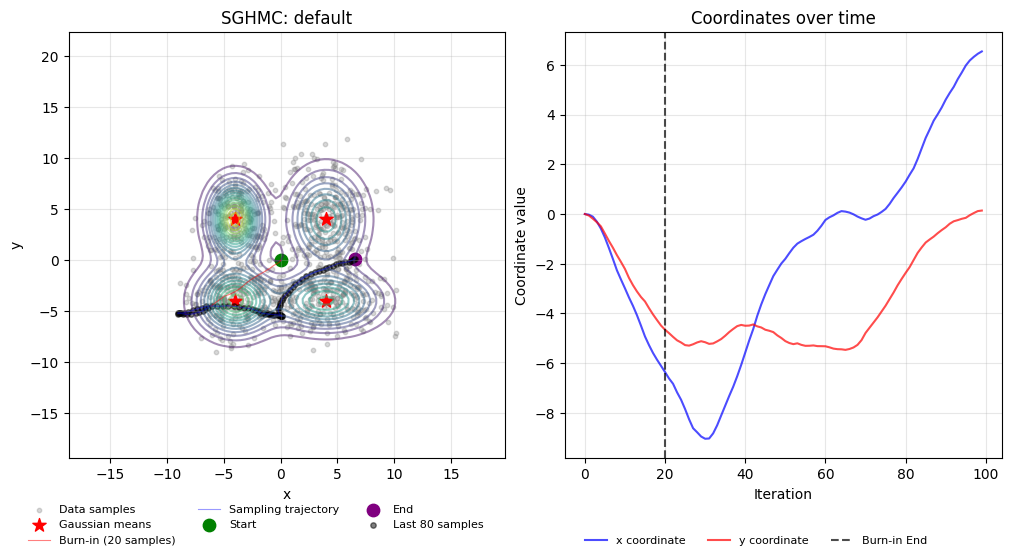

In [48]:
experiment_configs = [
    {
        "name": "default",
        "step_size": 0.2,
        "mdecay": 0.05,
        "burnin": 20,
    },
    #     {
    #         "name": "hogh_mdecay",
    #         "step_size": 0.2,
    #         "mdecay": 0.2,
    #         "burnin": 20,
    #     },
    #     {
    #         "name": "low_step_size",
    #         "step_size": 0.05,
    #         "mdecay": 0.05,
    #         "burnin": 20,
    #     },
]

for config in tqdm.tqdm(experiment_configs):
    trajectory = run_sequential_sghmc(
        sampler=sampler,
        data=samples,
        init_position=init_position,
        batch_size=100,
        num_samples=100,
        step_size=config["step_size"],
        mdecay=config["mdecay"],
        num_integration_steps=1,
        mresampling=0.01,
    )

    fig, axes = plot_gmm_sampling(
        trajectory=trajectory,
        samples=samples,
        means=means,
        covs=covs,
        weights=weights,
        gaussian_mixture_logprob=gaussian_mixture_logprob,
        title=f"SGHMC: {config['name']}",
        burnin=config["burnin"],
        figsize=(10, 5),
    )

    fig.savefig(
        f"results/sghmc_{config['name'].replace(' ', '_')}.png", dpi=300, bbox_inches="tight"
    )